# Read Data From CSV

## импорт всех библиотек

In [1]:
import plotly
import plotly.graph_objs as go
import plotly.express as px

from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from numpy.linalg import norm
from quaternion import Quaternion
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
import os
from os import walk
import madgwickahrs as mg
from quaternion import Quaternion


## функции калибровки

In [2]:

def find_offsets(mpu,counts = 100):
    calibration_set = mpu.loc[:counts]
    calibration_set =mpu 
    n = float(len(calibration_set))
    summ = []
    offsets = []
    for i in calibration_set:
        summ.append(calibration_set[i].sum())
    for s in summ:
        offsets.append(s/n)
    return offsets

def find_headers(mpu):
    headers = []
    for i in mpu:
        headers.append(i)
    return headers

def calibration(mpu,dataset):
    
    headers = find_headers(mpu)
#     print(headers)
    
    off = find_offsets(mpu)
    calibrated = mpu.copy()
    #не калибровать ускорение для фильтра маджвика!
    calibrated[headers[0]] = mpu[headers[0]] - off[0]
#  calibrated[headers[1]] = mpu[headers[1]] - off[1]
    calibrated[headers[2]] = mpu[headers[2]] - off[2]
    
    calibrated[headers[3]] = mpu[headers[3]] - off[3]
    calibrated[headers[4]] = mpu[headers[4]] - off[4]
    calibrated[headers[5]] = mpu[headers[5]] - off[5]
    
    return calibrated


In [3]:
#функции для вывода графиков
def show_plots(mpu_t,mpu_b,title_t,title_b,accel=None):
    
    headers_t = find_headers(mpu_t)
    headers_b = find_headers(mpu_b)
    
    if accel == True:
        headers_t = headers_t[:3]
        headers_b = headers_b[:3]
        title_t += ' accel'
        title_b += ' accel'
    elif accel == None:
        headers_t = headers_t[:3]
        title_t +='accel'
        headers_b = headers_b[3:]
        title_b += ' gyro'
    else:
        headers_t = headers_t[3:]
        headers_b = headers_b[3:]
        title_t += ' gyro'
        title_b += ' gyro'
        


    fig = make_subplots(rows=1, cols=2, subplot_titles=(title_t,title_b))


    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[0]],name=headers_t[0]),1,1)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[1]],name=headers_t[1]),1,1)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[2]],name=headers_t[2]),1,1)

    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[0]],name=headers_b[0]),1,2)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[1]],name=headers_b[1]),1,2)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[2]],name=headers_b[2]),1,2)


    fig.update_layout(legend_orientation="h",
                      legend=dict(x=.5, xanchor="center"),
                      hovermode="x",
                      margin=dict(l=0, r=0, t=40, b=0))
    fig.show()


def show_plot(mpu_t,title_t,accel=None):
    
    headers_t = find_headers(mpu_t)
    
    if accel == True:
        headers_t = headers_t[:3]
        title_t += ' accel'
    elif accel == None:
        headers_t = headers_t
    else:
        headers_t = headers_t[3:]
        title_t += ' gyro'
        


    fig = go.Figure() 
    fig.update_layout(title=title_t)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[0]],name=headers_t[0]))
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[1]],name=headers_t[1]))
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[2]],name=headers_t[2]))

    fig.show()


In [4]:
def read_csv_file(file_path):
    df = pd.read_csv(file_path,sep = ' ',header = None)
#     df = df_1.iloc[1:].reset_index(drop = True)
    df.columns = ["s1","bt_ax","bt_ay","bt_az","bt_gx","bt_gy","bt_gz",
                 "s2","bb_ax","bb_ay","bb_az","bb_gx","bb_gy","bb_gz",
                 "s3","lt_ax","lt_ay","lt_az","lt_gx","lt_gy","lt_gz",
                 "s4","lb_ax","lb_ay","lb_az","lb_gx","lb_gy","lb_gz",
                "s5","rt_ay","rt_ax","rt_az","rt_gx","rt_gy","rt_gz",
                 "s6","rb_ax","rb_ay","rb_az","rb_gx","rb_gy","rb_gz",
                 ]

    return df

In [5]:
#each  IMU for calibration
def parse_to_sensors(df):
    
    bt = df[["bt_ax","bt_ay","bt_az","bt_gx","bt_gy","bt_gz"]]
    bb = df[["bb_ax","bb_ay","bb_az","bb_gx","bb_gy","bb_gz"]]
    
    lt = df[["lt_ax","lt_ay","lt_az","lt_gx","lt_gy","lt_gz"]]
    lb = df[["lb_ax","lb_ay","lb_az","lb_gx","lb_gy","lb_gz"]]
    
    rt = df[["rt_ax","rt_ay","rt_az","rt_gx","rt_gy","rt_gz"]]
    rb = df[["rb_ax","rb_ay","rb_az","rb_gx","rb_gy","rb_gz"]]
    
#     rt = rt.rename(columns={"lt_ax": "rt_ax", })
#     rt =   -rt["rt_ax"]   
    return bt,bb,lt,lb,rt,rb


# Madgwick filter

In [6]:
def find_orientation(calibrated_mpu):
    
    headers = find_headers(calibrated_mpu)
        
    quaternions = []
#0.02
    heading = mg.MadgwickAHRS(sampleperiod = 1/14,beta =0.2)
    for i,row in calibrated_mpu.iterrows():
        gyro_d  = []
        accel_d = []
        gyro_d.append(row[headers[3]])
        gyro_d.append(row[headers[4]])
        gyro_d.append(row[headers[5]])
        accel_d.append(row[headers[0]])
        accel_d.append(row[headers[1]])
        accel_d.append(row[headers[2]])

        heading.update_imu(gyro_d,accel_d)
        quaternions.append(heading.quaternion._get_q())

    # print(quaternions)
    pitch = []
    roll = []
    yaw = []
    for i in range(len(quaternions)):
        pitch.append(np.arcsin(2 * quaternions[i][1] * quaternions[i][2] + 2 * quaternions[i][0] * quaternions[i][3]))
        if np.abs(quaternions[i][1] * quaternions[i][2] + quaternions[i][3] * quaternions[i][0] - 0.5) < 1e-8:
            roll.append(0) 
            yaw.append(2 * np.arctan2(quaternions[i][1], quaternions[i][0]))
        elif np.abs(quaternions[i][1] * quaternions[i][2] + quaternions[i][3] * quaternions[i][0] + 0.5) < 1e-8:
            roll.append(-2 * np.arctan2(quaternions[i][1], quaternions[i][0]))
            yaw.append(0)
        else:
            roll.append(np.arctan2(2 * quaternions[i][0] * quaternions[i][1] - 2 * quaternions[i][2] *quaternions[i][3], 1 - 2 * quaternions[i][1] ** 2 - 2 *quaternions[i][3] ** 2))
            yaw.append(np.arctan2(2 * quaternions[i][0] * quaternions[i][2] - 2 * quaternions[i][1] * quaternions[i][3], 1 - 2 * quaternions[i][2] ** 2 - 2 * quaternions[i][3] ** 2))


    orientation_d = pd.DataFrame({'roll':np.rad2deg(roll),'pitch':np.rad2deg(pitch),'yaw':np.rad2deg(yaw)})
    return orientation_d

    

# Функции калибровки и фильтрации

In [7]:
def all_calibrate(IMU_set,calibration_set):

    bt_1,bb_1,lt_1,lb_1,rt_1,rb_1=parse_to_sensors(IMU_set)
    bt_outl,bb_outl,lt_outl,lb_outl,rt_outl,rb_outl =  parse_to_sensors(calibration_set)




    calibrated_rt = calibration(rt_1,rt_outl)
    calibrated_rb = calibration(rb_1,rb_outl)
    calibrated_lt = calibration(lt_1,lt_outl)
    calibrated_lb = calibration(lb_1,lb_outl)
    calibrated_bt = calibration(bt_1,bt_outl)
    calibrated_bb = calibration(bb_1,bb_outl)
    
    
#     plt.figure(figsize=(16, 8))
#     plt.subplot(2,1, 1)
#     plt.title(f"Raw gyroscope data from left leg bottom sensor ")
#     plt.plot(bt_1.index, lb_1['lb_gx'], 'blue', alpha=0.75)
#     plt.plot(bt_1.index, lb_1['lb_gy'], 'green')
#     plt.plot(bt_1.index, lb_1['lb_gz'], 'orange')
#     plt.legend(('noisy gyro x', 'nosidy gyro y', 'noisy gyro z'), loc='best')
#     plt.grid(True)
#     plt.show()

    orientation_rt = find_orientation(calibrated_rt)
    orientation_lt = find_orientation(calibrated_lt)
    orientation_bb = find_orientation(calibrated_bb)
    orientation_bt = find_orientation(calibrated_bt)
    orientation_rb = find_orientation(calibrated_rb)
    orientation_lb = find_orientation(calibrated_lb)
    
#     plt.figure(figsize=(16, 8))
#     plt.subplot(2,1, 2)
#     plt.title(f"Calibrated gyroscope data from left leg bottom sensor")
#     plt.plot(calibrated_bt.index, calibrated_lb['lb_gx'], 'blue', alpha=0.75)
#     plt.plot(calibrated_bt.index, calibrated_lb['lb_gy'], 'green')
#     plt.plot(calibrated_bt.index, calibrated_lb['lb_gz'], 'orange')
#     plt.legend(('gyro x', 'gyro y', 'gyro z'), loc='best')
#     plt.grid(True)
#     plt.show()


    return   orientation_bt, -orientation_bb, orientation_lt, orientation_lb, -orientation_rt, orientation_rb
    


In [8]:
def preprocessing_dataset(dataset):
#     df = dataset.drop(columns = "Unnamed: 0")
    df = dataset
    df.columns = ["roll_bt","pitch_bt","yaw_bt",
                  "roll_bb","pitch_bb","yaw_bb",
                  "roll_lt","pitch_lt","yaw_lt",
                  "roll_lb","pitch_lb","yaw_lb",
                  "roll_rt","pitch_rt","yaw_rt",
                  "roll_rb","pitch_rb","yaw_rb"
                 ]
    return df


In [9]:
def filter_angles(dataset_test):
    
    headers_orient  = find_headers_orient(dataset_test)
    filtered_roll =  filter_scipy(dataset_test[headers_orient[0]])
    filtered_pitch =  filter_scipy(dataset_test[headers_orient[1]]) 
    filtered_yaw =  filter_scipy(dataset_test[headers_orient[2]])
    
    filtered_roll_pd = pd.DataFrame(filtered_roll)
    filtered_pitch_pd = pd.DataFrame(filtered_pitch)
    filtered_yaw_pd = pd.DataFrame(filtered_yaw)
    frame = pd.concat([filtered_roll_pd,filtered_pitch_pd,filtered_yaw_pd],axis = 1)
#     if headers_orient[0] == 'roll_lt' or 'roll_rt':
#         frame.columns = ["roll",  "yaw","pitch"]
#     else:
    frame.columns = ["roll", "pitch", "yaw"]
#     frame = frame[['yaw',"roll"]]
    return frame


In [10]:
def find_headers_orient(mpu):
    headers = []
    for i in mpu:
        headers.append(i)
    return headers


def filter_scipy(dataset,my_angle=False):
    xn = dataset
    b, a = signal.butter(3, 0.12)
    zi = signal.lfilter_zi(b, a)
    z, _ = signal.lfilter(b, a, xn, zi=zi* xn[0])
    z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
    y = signal.filtfilt(b, a, xn)
    if my_angle == True: 
    # вывод работы ФНЧ
        plt.plot(dataset.index, xn, 'b', alpha=0.75)
        plt.plot(dataset.index, z, 'r--', dataset.index, z2, 'r', dataset.index, y, 'k')
        plt.legend(('noisy signal', 'lfilter, once', 'lfilter, twice',
                'filtfilt'), loc='lower right')
        plt.grid(True)
#         plt.show()
    
    return y

def matplot_plot(frame,name_sensor_plot):
    plt.title(f"{name_sensor_plot}")
    plt.plot(frame.index,  frame['yaw'], 'g')
    plt.legend(('yaw'), loc='lower right')
    plt.grid(True)

    
def matplot_plot_bb(frame,name_sensor_plot):
    plt.title(f"{name_sensor_plot}")
    plt.plot(frame.index, frame['roll'], 'b', alpha=0.75)
    plt.legend(('roll'), loc='lower right')
    plt.grid(True)    
    
def plot_filtered_angles(fnch_bt,fnch_bb,fnch_lt,fnch_lb,fnch_rt,fnch_rb):
    matplot_plot_bb(fnch_bt,'Back top')
    matplot_plot_bb(fnch_bb,'Back bot')
    matplot_plot(fnch_lt,'Left top')
    matplot_plot(fnch_lb,'Left bottom')
    matplot_plot(fnch_rt,'Right top')
    matplot_plot(fnch_rb,'Right bottom')
    
        
    
def matplot_plot_back_last(frame):
#     plt.title(f"{name_sensor_plot}")
    plt.plot(frame.index,  frame, 'g')
    plt.legend(('roll_bt'), loc='lower right')
    plt.grid(True)

# Сборка датасета

In [11]:
def create_dataset(test_plot,number):
   
    test_plot_1 = preprocessing_dataset(test_plot)
    test_plot_1

    features = ['roll_bt','roll_bb','yaw_lt','yaw_lb','yaw_rt','yaw_rb']
    my_data = test_plot_1[features].loc[number:].reset_index(drop=True)
   
    return my_data



In [26]:
name = 'ahmad'
person = 10
filenames = next(walk(f'D:/Thesis/{name}/'), (None, None, []))[2]  # [] if no file

for i in range(len(filenames)):
    filename = f"D:/Thesis/{name}/{filenames[i]}"
    print(filename)
    IMU_set = read_csv_file(filename)
 
    calibration_set = IMU_set.copy()
    orientation_bt, orientation_bb, orientation_lt, orientation_lb, orientation_rt, orientation_rb =all_calibrate (IMU_set,calibration_set)


    fnch_bt = filter_angles(orientation_bt)
    fnch_bb = filter_angles(orientation_bb)
    fnch_lt = filter_angles(orientation_lt)
    fnch_lb = filter_angles(orientation_lb)
    fnch_rt = filter_angles(orientation_rt)
    fnch_rb = filter_angles(orientation_rb)
#     ready_dataset = pd.concat([fnch_bt, fnch_bb, fnch_lt, fnch_lb, fnch_rt, fnch_rb],axis = 1)    
    ready_dataset = pd.concat([orientation_bt, orientation_bb, orientation_lt, orientation_lb, orientation_rt, orientation_rb],axis = 1)  
#     plot_filtered_angles(fnch_bt,fnch_bb,fnch_lt,fnch_lb,fnch_rt,fnch_rb)

    ready_dataset.to_csv(f"D:\Thesis\dataset\lifting_orientation_{i}_{person}.csv", sep=",")
    dataset =  create_dataset(ready_dataset,70)

    dataset.to_csv(f"D:\Thesis\RNN\sample_{i}_{person}.csv", sep=",")


D:/Thesis/ahmad/15_ahmad.csv
D:/Thesis/ahmad/15_ahmad1.csv
D:/Thesis/ahmad/15_ahmad10.csv
D:/Thesis/ahmad/15_ahmad11.csv
D:/Thesis/ahmad/15_ahmad12.csv
D:/Thesis/ahmad/15_ahmad13.csv
D:/Thesis/ahmad/15_ahmad14.csv
D:/Thesis/ahmad/15_ahmad15.csv
D:/Thesis/ahmad/15_ahmad2.csv
D:/Thesis/ahmad/15_ahmad3.csv
D:/Thesis/ahmad/15_ahmad4.csv
D:/Thesis/ahmad/15_ahmad5.csv
D:/Thesis/ahmad/15_ahmad6.csv
D:/Thesis/ahmad/15_ahmad7.csv
D:/Thesis/ahmad/15_ahmad8.csv
D:/Thesis/ahmad/15_ahmad9.csv


10


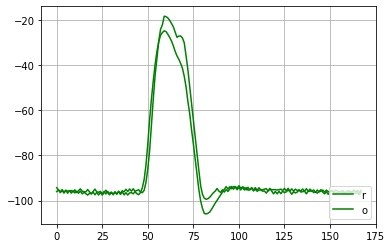

11


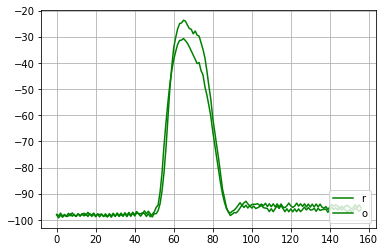

12


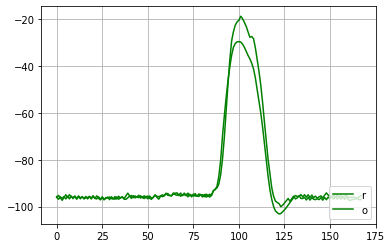

13


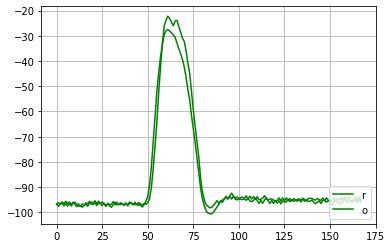

14


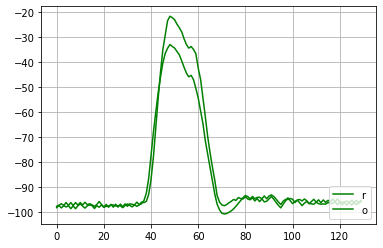

15


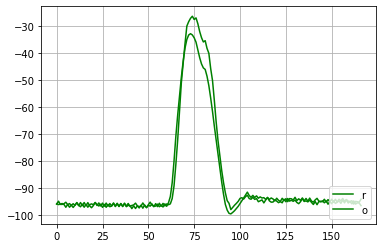

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Thesis\\RNN\\sample_16_10.csv'

In [49]:
for num  in range(10,20): 
    test_plot = pd.read_csv(f'D:\Thesis\RNN\sample_{num}_10.csv')
    print(num)
    matplot_plot_back_last(test_plot['roll_bt'])
    matplot_plot_back_last(test_plot['roll_bb'])
#     matplot_plot_back_last(test_plot['roll_bt'])
#     matplot_plot_back_last(test_plot['roll_bb'])
#     matplot_plot_back_last(test_plot['roll_bt'])
#     matplot_plot_back_last(test_plot['roll_bb'])

    plt.show()


In [ ]:
# matplot_plot_back_last(test_plot['yaw_lt'])
# matplot_plot_back_last(test_plot['yaw_lb'])

In [ ]:
# matplot_plot_back_last(test_plot['yaw_rt'])
# matplot_plot_back_last(test_plot['yaw_rb'])

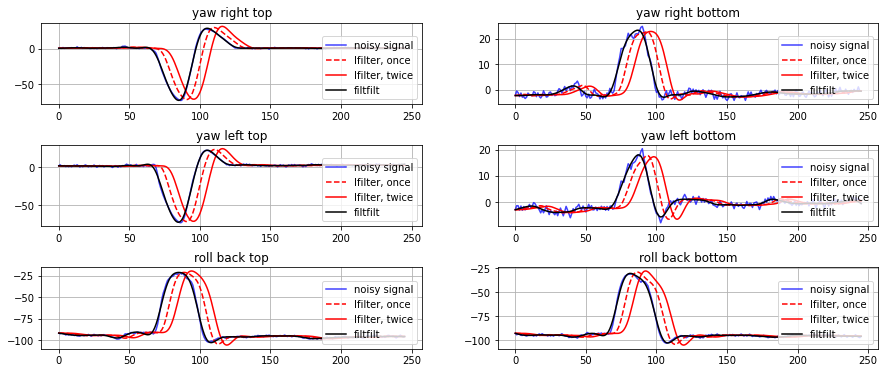

In [61]:
num = 3
test_plot = pd.read_csv(f'D:\Thesis\RNN\sample_{num}_7.csv')

plt.figure(figsize=(15, 6))

plt.subplot(3, 2, 1)
plt.subplots_adjust( hspace=0.5)

plt.title(f"yaw right top")
filtered_my_data=filter_scipy(test_plot['yaw_rt'],True)


plt.subplot(3,2, 2)
plt.title(f"yaw right bottom")
filtered_my_data=filter_scipy(test_plot['yaw_rb'],True)


plt.subplot(3,2, 3)
plt.title(f"yaw left top")
filtered_my_data=filter_scipy(test_plot['yaw_lt'],True)


plt.subplot(3,2, 4)
plt.title(f"yaw left bottom")
filtered_my_data=filter_scipy(test_plot['yaw_lb'],True)


plt.subplot(3,2, 5)
plt.title(f"roll back top")
filtered_my_data=filter_scipy(test_plot['roll_bt'],True)

plt.subplot(3,2, 6)
plt.title(f"roll back bottom")
filtered_my_data=filter_scipy(test_plot['roll_bb'],True)


plt.show()

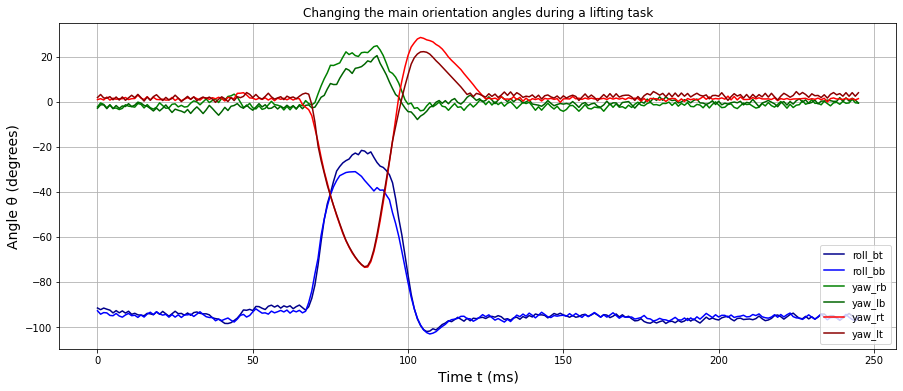

In [62]:

plt.figure(figsize=(15, 6))

plt.xlabel(r'Time t (ms)', fontsize=14)
plt.ylabel(r'Angle θ (degrees)', fontsize=14)


plt.title(f"Changing the main orientation angles during a lifting task")
plt.plot(test_plot.index,  test_plot['roll_bt'], 'darkblue')
plt.plot(test_plot.index,  test_plot['roll_bb'], 'blue')

plt.plot(test_plot.index,  test_plot['yaw_rb'], 'green')
plt.plot(test_plot.index,  test_plot['yaw_lb'], 'darkgreen')

plt.plot(test_plot.index,  test_plot['yaw_rt'], 'red')
plt.plot(test_plot.index,  test_plot['yaw_lt'], 'darkred')


plt.legend(('roll_bt','roll_bb','yaw_rb','yaw_lb','yaw_rt','yaw_lt'), loc='lower right')
plt.grid(True)

plt.show()

In [ ]:

test_plot

In [ ]:
# name = 'test'
# сalibration_set= read_csv_file(f'calibration/30_calibration.csv')

# сalibration_file = read_csv_file(f"D:/Thesis/test/20_all_legs1.csv")
# filenames = next(walk(f'D:/Thesis/{name}/'), (None, None, []))[2]  # [] if no file
# filenames[0]
# for i in range(len(filenames)):
#     filename = f"D:/Thesis/{name}/{filenames[i]}"
#     print(filename)
#     IMU_set = read_csv_file(filename)
#     orientation_bt, orientation_bb, orientation_lt, orientation_lb, orientation_rt, orientation_rb = all_calibrate(IMU_set)
#     ready_dataset = pd.concat([orientation_bt, orientation_bb, orientation_lt, orientation_lb, orientation_rt, orientation_rb],axis = 1)    
#     #     print(ready_dataset)
#     ready_dataset.to_csv(f"D:\Thesis\dataset\lifting_orientation_{i}_0.csv", sep=",")


In [ ]:

# plt.figure
# plt.plot(orientation_lb_test.index, orientation_lb_test["roll_lb"], 'b', alpha=0.75)
# plt.plot(orientation_lb_test.index, frame['pitch'], 'r', orientation_lb_test.index,  orientation_lb_test["yaw_lb"], 'g')
# plt.legend(('roll', 'pitch', 'yaw'), loc='best')
# plt.grid(True)
# plt.show()


In [ ]:
# orientation_lb_test.loc[:]

# Filter dataset

In [ ]:
# xn = orientation_lb_test['yaw_lb']
# b, a = signal.butter(3, 0.05)
# zi = signal.lfilter_zi(b, a)
# z, _ = signal.lfilter(b, a, orientation_lb_test['yaw_lb'], zi=zi* orientation_lb_test['yaw_lb'][0])

In [ ]:
# z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
# y = signal.filtfilt(b, a, xn)


In [ ]:

# filtered_roll_pd = pd.DataFrame(filtered_roll)
# filtered_pitch_pd = pd.DataFrame(filtered_pitch)
# filtered_yaw_pd = pd.DataFrame(filtered_yaw)
# frame = pd.concat([filtered_roll_pd,filtered_pitch_pd,filtered_yaw_pd],axis = 1)
# frame.columns = ["roll", "pitch", "yaw"]
# frame

In [ ]:
# i = input()
# test_plot = pd.read_csv(f'D:/Thesis/dataset/lifting_orientation_0_0.csv')


# test_plot_1 = preprocessing_dataset(test_plot)


# bt_h = ["roll_bt","pitch_bt","yaw_bt"]
# bb_h = ["roll_bb","pitch_bb","yaw_bb"]
# lt_h = [ "roll_lt","pitch_lt","yaw_lt"]
# lb_h = ["roll_lb","pitch_lb","yaw_lb"]
# rt_h =["roll_rt","pitch_rt","yaw_rt"]
# rb_h = [ "roll_rb","pitch_rb","yaw_rb"]
                 
# name_sensor_plot = 'lb_h'

# orientation_bt_test= test_plot_1[bt_h]
# orientation_bb_test= test_plot_1[bb_h]
# orientation_lt_test= test_plot_1[lt_h]
# orientation_lb_test= test_plot_1[lb_h]
# orientation_rt_test= test_plot_1[rt_h]
# orientation_rb_test= test_plot_1[rb_h]


# frame_bt = filter_angles(orientation_bt_test)
# frame_bb = filter_angles(orientation_bb_test)
# frame_lt = filter_angles(orientation_lt_test)
# frame_lb = filter_angles(orientation_lb_test)
# frame_rt = filter_angles(orientation_rt_test)
# frame_rb = filter_angles(orientation_rb_test)


# # frame = frame.loc[15:]
# plt.figure(figsize=(14, 7))
# plt.subplots_adjust(hspace=1)



# plt.subplot(3, 2, 1)
# matplot_plot(frame_bt,'back top sensor')

# plt.subplot(3, 2, 2)
# matplot_plot(frame_bb,'back bottom sensor')


# plt.subplot(3, 2,3)
# matplot_plot(frame_lt,'left  top sensor')

# plt.subplot(3, 2,4)
# matplot_plot(frame_lb,'left  bottom sensor')


# plt.subplot(3, 2, 5)
# matplot_plot(frame_rt,'right  top sensor')


# plt.subplot(3, 2, 6)
# matplot_plot(frame_rb,'right bottom sensor')
# plt.show()


In [ ]:
test_plot = pd.read_csv(f'D:/Thesis/dataset/lifting_orientation_0_0.csv')
test_plot_1 = preprocessing_dataset(test_plot)
test_plot_1

features = ['roll_bt','roll_bb','yaw_lt','yaw_lb','yaw_rt','yaw_rb']
my_data = test_plot_1[features].loc[10:].reset_index(drop=True)
my_data



In [ ]:
test_plot = pd.read_csv(f'D:/Thesis/RNN/sample_0_0.csv')
test_plot

# Orientation only with gyro 

In [ ]:
plt.figure(figsize=(8, 4))
plt.title(f"yaw left_top")
filtered_my_data=filter_scipy(my_data['yaw_lt'],True)


plt.figure(figsize=(8, 4))
plt.title(f"yaw right_top")
filtered_my_data=filter_scipy(my_data['yaw_rt'],True) 

plt.figure(figsize=(8, 4))
plt.title(f"yaw left_bottom")
filtered_my_data=filter_scipy(my_data['yaw_lb'],True) 

In [ ]:
plt.figure(figsize=(8, 4))
plt.title(f"roll back_top")
filtered_my_data=filter_scipy(my_data['roll_bt']*-1,True) 
plt.figure(figsize=(8,4))
plt.title(f"roll back_bottom")
filtered_my_data=filter_scipy(my_data['roll_bb'],True) 


In [ ]:
plt.figure(figsize=(8, 4))
plt.title(f"yaw right_top")
filtered_my_data=filter_scipy(my_data['yaw_rt'],True) 
plt.figure(figsize=(8, 4))
plt.title(f"yaw right_bottom")
filtered_my_data=filter_scipy(my_data['yaw_rb'],True) 

In [ ]:


# pitch = np.zeros(len(calibrated_lb))
# yaw = np.zeros(len(calibrated_lb))
# roll = np.zeros(len(calibrated_lb))

# for i in range(len(calibrated_lb)-1):
#     delta_t = 0.06
    
#     pitch[i+1] = pitch[i] + calibrated_lb['lb_gy'][i]*delta_t
#     yaw[i+1] = yaw[i]+calibrated_lb['lb_gz'][i]*delta_t
#     roll[i+1] = roll[i]+calibrated_lb['lb_gx'][i]*delta_t
    

# orientation_d = pd.DataFrame({'roll':np.rad2deg(roll),'pitch':np.rad2deg(pitch),'yaw':np.rad2deg(yaw)})

# show_plot(orientation_d,'Orientation only with  gyro')

In [ ]:
#(-0.02213089742574257, 0.01005698124752475, -0.013309934386138617)